In [1]:
import os
import cv2
import time
import numpy as np
import face_recognition
from scipy import spatial
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
seed = 2020
testsplit = 3./10
data_path = 'datasets/'
threshold, tolerance = 0.95, 0.6
def flow_from_directory(generator, batch_size, subset, shuffle):
    return generator.flow_from_directory(data_path,
                                            target_size=(1080, 1920),
                                            batch_size=batch_size,
                                            color_mode='rgb', # 'grayscale',
                                            class_mode='binary',
                                            subset=subset,
                                            shuffle=shuffle,
                                            seed=seed)

def load_dataset():
    generator = ImageDataGenerator(validation_split=testsplit,
                                            # rescale=1./255,
                                            rotation_range=10,
                                            zoom_range=0.1,
                                            # width_shift_range=0.1,
                                            # height_shift_range=0.1,
                                            brightness_range=[0.8, 1.3], # [0.1, 1.5]
                                            # shear_range=0.1,
                                            # preprocessing_function=preprocess_input
                                            horizontal_flip=True,
                                            fill_mode="nearest"
                                        )
    train_data = flow_from_directory(generator, 1, 'training', True)
    test_data = flow_from_directory(generator, 1, 'validation', False)
  
    return train_data, test_data

In [3]:
train_data, test_data = load_dataset()

Found 10080 images belonging to 24 classes.
Found 4320 images belonging to 24 classes.


In [4]:
encodings, names = [], []
print(time.ctime())

filepaths = train_data.filepaths

start_time = time.time()
for filename in filepaths:
    label = filename.split('/')[1]
    img = face_recognition.load_image_file(filename)
    face_enc = face_recognition.face_encodings(img)
    if face_enc and len(face_enc) == 1:
        encodings.append(face_enc[0])
        names.append(label)
end_time = time.time()
print('\nRun-time: %fs\n' % (end_time-start_time))

encodings = np.array(encodings)
names = np.array(names)
with open('encodings_cosine.npy', 'wb') as f:
    np.save(f, encodings)
with open('names_cosine.npy', 'wb') as f:
    np.save(f, names)
print('Encodings Complete')

Fri Aug 14 00:15:03 2020

Run-time: 9555.233046s

Encodings Complete


In [5]:
def face_distance(face_encodings, face_to_compare):
    if len(face_encodings) == 0:
        return np.empty((0))
    # normed = np.linalg.norm(face_encodings - face_to_compare, axis=1)
    # return normed.T * normed
    #----
    arr = []
    for face_encoding in face_encodings:
        arr.append(spatial.distance.cosine(face_encoding, face_to_compare))

    return np.array(arr)

In [6]:
y_true = test_data.labels
y_pred = []

for filename in test_data.filepaths:
    img = face_recognition.load_image_file(filename)
    face_enc = face_recognition.face_encodings(img)
    if face_enc and len(face_enc) > 0:
        distance = face_distance(encodings, face_enc[0])
        matchIndex = np.argmin(distance)
        confidence = 1 - distance[matchIndex]
        if distance[matchIndex] <= tolerance and confidence >= threshold:
            y_pred.append(names[matchIndex])
        else:
            y_pred.append(-1)
    else:
        y_pred.append(-1)
        # break
y_pred = np.array(y_pred)

{'B1509922': 0, 'B1605203': 1, 'B1605247': 2, 'B1707567': 3, 'B1709618': 4, 'B1709632': 5, 'B1804734': 6, 'B1804804': 7, 'B1810377': 8, 'B1811124': 9, 'B1811153': 10, 'B1812179': 11, 'B1904428': 12, 'B1905858': 13, 'B1905870': 14, 'B1905871': 15, 'B1905921': 16, 'B1906279': 17, 'B1907324': 18, 'B1907905': 19, 'B1911460': 20, 'B1911461': 21, 'B1911465': 22, 'Dc1532m541': 23}
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  0 180   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  0   0 180   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  0   0   0 180   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  0   0   0   0 180   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  0   0   0   0   0 180   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   

[Text(0.5, 0, 'B1509922'),
 Text(1.5, 0, 'B1605203'),
 Text(2.5, 0, 'B1605247'),
 Text(3.5, 0, 'B1707567'),
 Text(4.5, 0, 'B1709618'),
 Text(5.5, 0, 'B1709632'),
 Text(6.5, 0, 'B1804734'),
 Text(7.5, 0, 'B1804804'),
 Text(8.5, 0, 'B1810377'),
 Text(9.5, 0, 'B1811124'),
 Text(10.5, 0, 'B1811153'),
 Text(11.5, 0, 'B1812179'),
 Text(12.5, 0, 'B1904428'),
 Text(13.5, 0, 'B1905858'),
 Text(14.5, 0, 'B1905870'),
 Text(15.5, 0, 'B1905871'),
 Text(16.5, 0, 'B1905921'),
 Text(17.5, 0, 'B1906279'),
 Text(18.5, 0, 'B1907324'),
 Text(19.5, 0, 'B1907905'),
 Text(20.5, 0, 'B1911460'),
 Text(21.5, 0, 'B1911461'),
 Text(22.5, 0, 'B1911465'),
 Text(23.5, 0, 'Dc1532m541')]

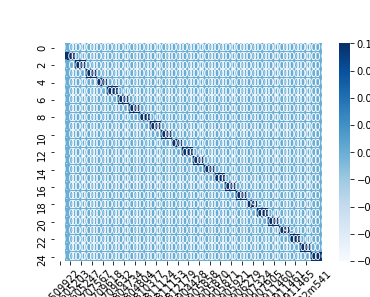

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

print(train_data.class_indices)
cm = confusion_matrix(y_true, y_pred)
print(cm)
cm = cm / cm.astype(np.float).sum(axis=1)
# print(cm)
g = sns.heatmap(cm, annot=True, fmt='.2f', cmap="Blues", xticklabels=list(test_data.class_indices.keys()))
g.set_xticklabels(g.get_xticklabels(), rotation = 45,)
#annot=True to annotate cells

In [10]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_true, y_pred)
print('Accuracy', acc)

Accuracy 0.9990740740740741


In [8]:
os.system("say Experiment has finished. Please collect your result")

0